In [2]:
# Import necessary PyTorch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import kornia.augmentation as A
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import sys
import random
from tqdm import tqdm
from tasks.batch import Batch

from utils.backdoor import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD, IMAGENET_MIN, IMAGENET_MAX
from attack_models.autoencoders import ConditionalAutoencoder
from attack_models.unet import UNet
from models.resnet_cifar import ResNet18
from tasks.batch import Batch

In [3]:
tgtmodel = ConditionalAutoencoder(n_classes=10, input_dim=32).to("cuda")
# tgtmodel = UNet(3).to("cuda")
model = ResNet18().to("cuda")

# prefix = f"/hdd/home/ssd_data/Son/LRBA/saved_models/model_CIFAR10_01.21_16.01.49_cifar10"
prefix = "/hdd/home/ssd_data/Son/Venomancer/saved_models/model_CIFAR10_01.25_22.02.06_cifar10"
path = prefix + "/model_last.pt.tar"
with open(path, "rb") as f:
    checkpoint = torch.load(f, map_location="cuda")
    model.load_state_dict(checkpoint["state_dict"])
    tgtmodel.load_state_dict(checkpoint["tgt_state_dict"])


# with open(path, "rb") as f:
#     checkpoint = torch.load(f, map_location="cuda")
#     model.load_state_dict(checkpoint["state_dict"])

# with open(path, "rb") as f:
#     checkpoint = torch.load(f, map_location="cuda")
#     tgtmodel.load_state_dict(checkpoint["tgt_state_dict"])

tgtoptimizer = torch.optim.Adam(tgtmodel.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [7]:
normalize = transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)

# transform_train = transforms.Compose([transforms.ToTensor(),])
        
transform_test = transforms.Compose([transforms.ToTensor(), normalize])
# transform_test = transforms.Compose([transforms.ToTensor(),])

# train_dataset = torchvision.datasets.CIFAR10(
#                         root=".data/",
#                         train=True,
#                         download=True,
#                         transform=transform_train)

# train_loader = DataLoader(train_dataset,
#                         batch_size=64,
#                         shuffle=True,
#                         num_workers=0)
test_dataset = torchvision.datasets.CIFAR10(
                        root=".data/",
                        train=False,
                        download=True,
                        transform=transform_test)
test_loader = DataLoader(test_dataset,
                        batch_size=64,
                        shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

clip_image = lambda x: torch.clamp(x, IMAGENET_MIN, IMAGENET_MAX)
# target_transform = lambda x: torch.ones_like(x) * 8

def sample_negative_labels(label, n_classes):
    label_cpu = label.detach().cpu().numpy()
    neg_label = [np.random.choice([e for e in range(n_classes) if e != l], 1)[0] for l in label_cpu]
    neg_label = torch.tensor(np.array(neg_label))
    return neg_label.to('cuda')

def make_backdoor_batch(data, target, atkmodel, target_transform, multitarget=False):
    global clip_image
    if multitarget:
        atktarget = target_transform(target, n_classes=10)
        # noise = atkmodel(data, atktarget) * hlpr.params.eps
        noise = atkmodel(data, atktarget)
        # noise = torch.clamp(noise, -hlpr.params.eps, hlpr.params.eps)
        atkdata = clip_image(data + noise)
    else:
        noise = atkmodel(data) * 0.05
        # noise = atkmodel(data)
        # noise = torch.clamp(noise, -hlpr.params.eps, hlpr.params.eps)
        atkdata = clip_image(data + noise)
        atktarget = target_transform(target)

    return atkdata, atktarget

target_transform = sample_negative_labels
# target_label = 0
# target_transform = lambda x: torch.ones_like(x) * target_label

Files already downloaded and verified


In [8]:
def imshow(img):
    plt.figure(figsize=(8, 8))
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

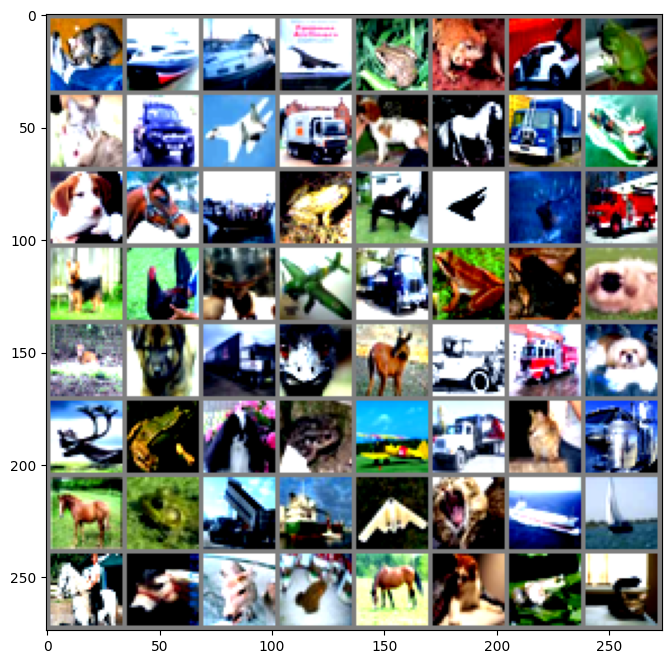

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3], device='cuda:0')
  cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog  deer   dog truck  bird  deer   car truck   dog  deer  frog   dog  frog plane truck   cat truck horse  frog truck  ship plane   cat  ship  ship horse horse  deer  frog horse   cat  frog   cat


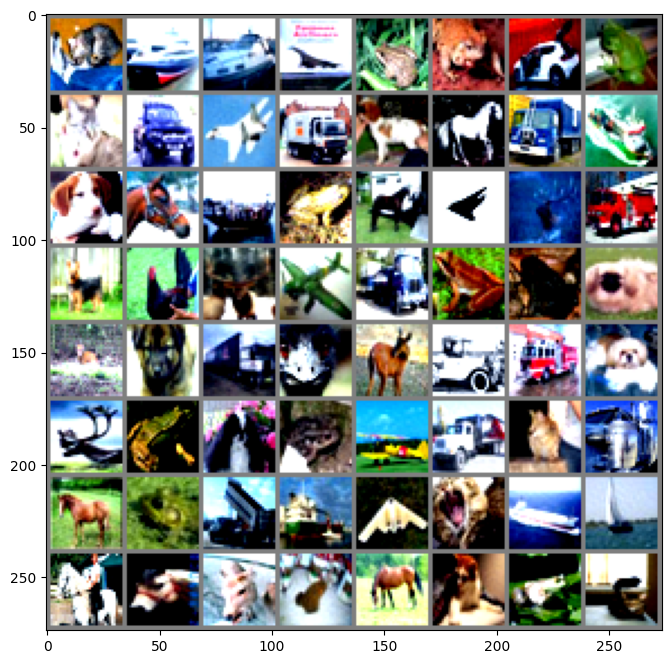

tensor([0, 7, 3, 5, 0, 9, 6, 0, 6, 4, 7, 3, 7, 1, 7, 6, 8, 9, 4, 2, 8, 2, 5, 6,
        9, 3, 6, 9, 0, 4, 7, 7, 7, 0, 1, 1, 9, 7, 4, 0, 7, 3, 4, 3, 7, 7, 7, 8,
        4, 1, 4, 6, 8, 4, 3, 3, 3, 9, 8, 7, 2, 2, 0, 2], device='cuda:0')
  dog   car   car   car  frog  frog   cat  bird   cat   car horse truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck  deer  bird  frog plane   car  deer  frog   dog  ship   car truck   car  deer   car truck   dog  deer  frog   cat  frog plane truck   dog truck  deer  bird truck  ship horse  frog  ship  ship horse   dog   cat   cat horse  bird  frog   cat


In [9]:
# Get a batch of data
data, target = next(iter(test_loader))
data, target = data.to('cuda'), target.to('cuda')

atkdata, atktarget = make_backdoor_batch(data, target, tgtmodel, target_transform, multitarget=True)
atkoutput = model(atkdata)
atkpred = atkoutput.max(1, keepdim=True)[1]  # get the index of the max log-probability

# Show images
imshow(torchvision.utils.make_grid(data))
print(target)
print(' '.join('%5s' % classes[target[j]] for j in range(64)))
imshow(torchvision.utils.make_grid(atkdata))
print(atktarget)
print(' '.join('%5s' % classes[atkpred[j]] for j in range(64)))

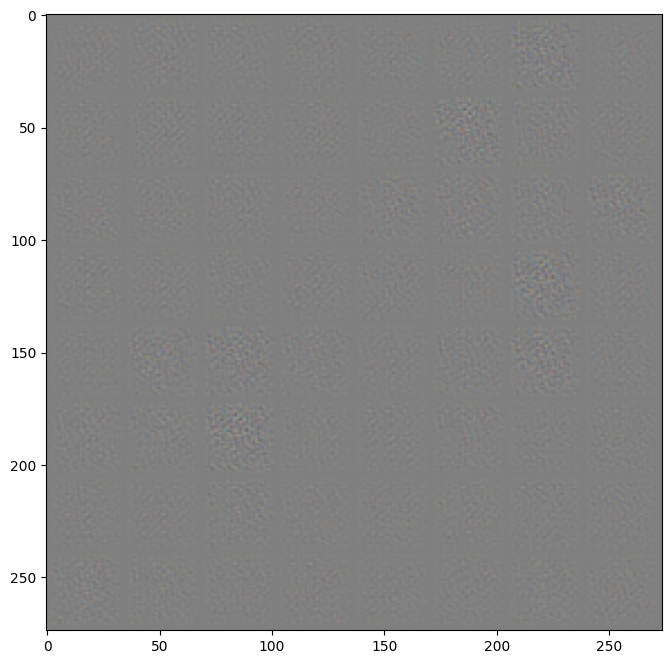

In [10]:
diff = atkdata - data
imshow(torchvision.utils.make_grid(diff))

In [14]:
def get_batch(batch_id, data) -> Batch:
    """Process data into a batch.

    Specific for different datasets and data loaders this method unifies
    the output by returning the object of class Batch.
    :param batch_id: id of the batch
    :param data: object returned by the Loader.
    :return:
    """
    inputs, labels = data
    batch = Batch(batch_id, inputs, labels)
    return batch.to("cuda")

In [15]:
criterion = torch.nn.CrossEntropyLoss(reduction='none')

model.eval()
test_loss, correct = 0.0, 0
test_backdoor_loss, backdoor_correct = 0.0, 0
with torch.no_grad():
    for i, data_labels in tqdm(enumerate(test_loader)):
        batch = get_batch(i, data_labels)
        
        data, target = batch.inputs, batch.labels
        output = model(data)
        test_loss += criterion(output, target).sum().item()
        pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        if tgtmodel:
            # target_transform = hlpr.task.target_transform
            target_transform = sample_negative_labels
            # atkdata, atktarget = make_backdoor_batch(hlpr, data, target, atkmodel, target_transform, multitarget=False)
            atkdata, atktarget = make_backdoor_batch(data, target, tgtmodel, target_transform, multitarget=True)

            visual_diff = torch.sum(torch.square(atkdata - data), dim=(1, 2, 3))

            atkoutput = model(atkdata)

            test_backdoor_loss += criterion(atkoutput, atktarget).sum().item()
            atkpred = atkoutput.max(1, keepdim=True)[1]  # get the index of the max log-probability
            backdoor_correct += atkpred.eq(atktarget.view_as(atkpred)).sum().item()

test_loss /= len(test_loader.dataset)
acc = correct / len(test_loader.dataset)

if tgtmodel:
    test_backdoor_loss /= len(test_loader.dataset)
    backdoor_acc = backdoor_correct / len(test_loader.dataset)

    # print('\nTest [{}]: Clean Loss {:.4f}, Backdoor Loss {:.4f}, Clean Accuracy {:.4f}, Backdoor Accuracy {:.4f}, Visual Difference {:.4f}'.format(epoch,
    #         test_loss, test_backdoor_loss, acc, backdoor_acc, visual_diff.mean().item()))

157it [00:02, 75.48it/s]


In [16]:
acc, backdoor_acc

(0.6579, 0.9375)

In [57]:
import pytorch_ssim
import torch
from torch.autograd import Variable

img1 = Variable(torch.rand(4, 1, 256, 256))
img2 = Variable(torch.rand(4, 1, 256, 256))

huber_loss = torch.nn.HuberLoss(reduction='none', delta=1.0)
huber_loss(img1, img2).sum(dim=(1, 2, 3))

tensor([5473.4277, 5458.8857, 5522.0820, 5473.2646])

In [58]:
IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
IMAGENET_MIN  = ((np.array([0,0,0]) - np.array(IMAGENET_DEFAULT_MEAN)) / np.array(IMAGENET_DEFAULT_STD)).min()
IMAGENET_MAX  = ((np.array([1,1,1]) - np.array(IMAGENET_DEFAULT_MEAN)) / np.array(IMAGENET_DEFAULT_STD)).max()

In [61]:
IMAGENET_MIN, IMAGENET_MAX

(-2.1179039301310043, 2.6399999999999997)

In [9]:
def get_batch(batch_id, data):
    """Process data into a batch.

    Specific for different datasets and data loaders this method unifies
    the output by returning the object of class Batch.
    :param batch_id: id of the batch
    :param data: object returned by the Loader.
    :return:
    """
    inputs, labels = data
    batch = Batch(batch_id, inputs, labels)
    return batch.to('cuda')

In [10]:
criterion = nn.CrossEntropyLoss(reduction='none')

def test(epoch, backdoor=False, model=None, atkmodel=None, criterion=None, test_loader=None, target_transform=None):
    model.eval()
    # hlpr.task.reset_metrics()

    test_loss, correct = 0.0, 0
    test_backdoor_loss, backdoor_correct = 0.0, 0
    with torch.no_grad():
        for i, data_labels in tqdm(enumerate(test_loader)):
            batch = get_batch(i, data_labels)
            
            data, target = batch.inputs, batch.labels
            output = model(data)
            test_loss += criterion(output, target).sum().item()
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            if atkmodel:
                # target_transform = hlpr.task.target_transform
                target_transform = target_transform
                atkdata, atktarget = make_backdoor_batch(hlpr, data, target, atkmodel, target_transform, multitarget=False)
                # atkdata, atktarget = make_backdoor_batch(data, target, atkmodel, target_transform, multitarget=True)
                atkoutput = model(atkdata)

                test_backdoor_loss += criterion(atkoutput, atktarget).sum().item()
                atkpred = atkoutput.max(1, keepdim=True)[1]  # get the index of the max log-probability
                backdoor_correct += atkpred.eq(atktarget.view_as(atkpred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)

    if atkmodel:
        test_backdoor_loss /= len(test_loader.dataset)
        backdoor_acc = backdoor_correct / len(test_loader.dataset)

        print('\nTest [{}]: Clean Loss {:.4f}, Backdoor Loss {:.4f}, Clean Accuracy {:.4f}, Backdoor Accuracy {:.4f}'.format(epoch,
                test_loss, test_backdoor_loss, acc, backdoor_acc))
        return acc, backdoor_acc, test_loss, test_backdoor_loss
    else:
        # raise the error that informs the user atkmodel is None using raise
        raise ValueError("atkmodel is None")

In [11]:
test(0, backdoor=False, model=model, atkmodel=tgtmodel, criterion=criterion, test_loader=test_loader, target_transform=target_transform)

157it [00:02, 57.40it/s]


Test [0]: Clean Loss 0.3889, Backdoor Loss 0.2615, Clean Accuracy 0.8806, Backdoor Accuracy 0.9386


(0.8806, 0.9386, 0.38891612277030946, 0.26151237789392473)